In [2]:
data_dir = '/data/shamoutlab/mimic-iv-extracted/'
img_dir = '/data/shamoutlab/'
code_dir = '/data/farah/code/mml-ehr-imaging/contrastive-learning/'
task = 'phenotyping'

# Import libraries
import sys
#sys.path.append(f'{code_dir_medfuse}')
import numpy as np
import argparse
import os
import importlib as imp
import re
from pathlib import Path
import pandas as pd
import neptune.new as neptune

## Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# from tqdm.notebook import tqdm
# import matplotlib
# matplotlib.use('Agg')

# Import Pytorch 
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from PIL import Image



## Performance metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score

# Import custom functions
import parser as par
import data_utils as prep
# from fusion_trainer_farah import FusionTrainer
# from mmtm_trainer import MMTMTrainer
# from daft_trainer import DAFTTrainer


# Import functions from MedFuse
from datasets.ehr_dataset import get_datasets
from datasets.cxr_dataset import get_cxr_datasets, visualize_transforms_simclr
from datasets.fusion import load_cxr_ehr
from ehr_preprocess import ehr_funcs
#from SimCLR import train_simclr, SimCLR

sys.path.append('/home/shamoutlab/.local/bin')

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


from copy import deepcopy
from tqdm.notebook import tqdm

In [ ]:
from torch.optim import *

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc = nn.Linear(1, 10)
    def forward(self,x):
        return self.fc(x)

In [213]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 9.866357858642206e-07,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0.001,
   'nesterov': False,
   'initial_lr': 0.001,
   'params': [0, 1]}]}

Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch     1: adjusting learning rate of group 0 to 9.9999e-04.
Epoch     2: adjusting learning rate of group 0 to 9.9996e-04.
Epoch     3: adjusting learning rate of group 0 to 9.9991e-04.
Epoch     4: adjusting learning rate of group 0 to 9.9984e-04.
Epoch     5: adjusting learning rate of group 0 to 9.9975e-04.
Epoch     6: adjusting learning rate of group 0 to 9.9964e-04.
Epoch     7: adjusting learning rate of group 0 to 9.9952e-04.
Epoch     8: adjusting learning rate of group 0 to 9.9937e-04.
Epoch     9: adjusting learning rate of group 0 to 9.9920e-04.
Epoch    10: adjusting learning rate of group 0 to 9.9901e-04.
Epoch    11: adjusting learning rate of group 0 to 9.9881e-04.
Epoch    12: adjusting learning rate of group 0 to 9.9858e-04.
Epoch    13: adjusting learning rate of group 0 to 9.9833e-04.
Epoch    14: adjus

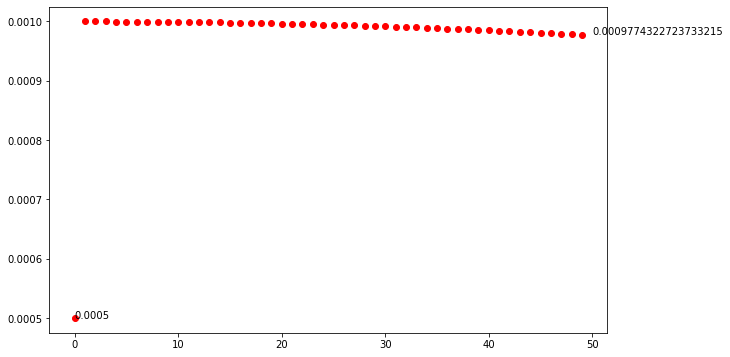

[0.0005, 0.001, 0.0009999901304280686, 0.0009999605221019082, 0.0009999111761904045, 0.00099984209464165, 0.0009997532801828658, 0.0009996447363202947, 0.0009995164673390624, 0.0009993684783030088, 0.0009992007750544876, 0.0009990133642141358, 0.0009988062531806126, 0.000998579450130307, 0.0009983329640170149, 0.0009980668045715864, 0.00099778098230154, 0.0009974755084906502, 0.0009971503951984994, 0.0009968056552600042, 0.0009964413022849068, 0.000996057350657239, 0.0009956538155347532, 0.0009952307128483257, 0.0009947880593013255, 0.000994325872368957, 0.0009938441702975688, 0.000993342972103934, 0.000992822297574499, 0.0009922821672646027, 0.0009917226024976648, 0.0009911436253643444, 0.000990545258721667, 0.0009899275261921235, 0.000989290452162736, 0.0009886340617840967, 0.0009879583809693738, 0.0009872634363932886, 0.0009865492554910634, 0.000985815866457337, 0.000985063298245053, 0.0009842915805643156, 0.0009835007438812175, 0.000982690819416637, 0.0009818618391450049, 0.0009810

In [215]:
import flash
from flash.core.optimizers import LARS

lrs = []
model = Net()
batchsize=512
LR = 0.001
epochs = 50
warmup_epochs= int(0.05*epochs)


optimizer = LARS(model.parameters(), lr=0.001, momentum=0.9, weight_decay=10e-4)
lambda1= lambda epoch_n : (epoch_n+1)/warmup_epochs
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, verbose=True)
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1, verbose=True)


for epoch in range(epochs): 
#     optimizer.step()
    lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])
    if epoch<warmup_epochs-1:
        warmupscheduler.step()
    elif epoch >= warmup_epochs-1:
        mainscheduler.step()

    
plt.figure(figsize=(10, 6))   
plt.plot(lrs, 'o', color='r')
plt.text(0, lrs[0], str(lrs[0]))
plt.text(epochs, lrs[-1], str(lrs[-1]))
plt.show()

print(lrs)

In [22]:
CHECKPOINT_PATH = code_dir+'checkpoints/'
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print('Using {} device...'.format(device))

parser = par.initiate_parsing()
modality='med_fuse'
if modality == 'med_fuse':
    save_dir = f'results/{task}/med_fuse'
    fusion_type = 'lstm'
    load_state_prefix = '--load_state'    
    vision_num_classes = '14'
    if task == 'phenotyping':
        num_classes = '25'
        labels_set = 'pheno'
            #load_state = f'{code_dir_medfuse}/checkpoints/pheno/ablation2/lstm_joint_0.2/best_checkpoint.pth.tar'
    else:
        num_classes = '1'
        labels_set = 'mor'
            #load_state = f'{code_dir_medfuse}/checkpoints/mortality/ablation2/lstm_joint_0.1/best_checkpoint.pth.tar'

impl = 'simclrv2'
args = parser.parse_args(['--dropout', '0.3', 
        '--mode', 'eval',
        '--layers', '2', '--vision_num_classes', vision_num_classes, '--num_classes', num_classes,
        '--vision-backbone', 'resnet34',
        '--batch_size', '48', '--save_dir', save_dir,
        '--fusion_type', fusion_type,  '--data_pairs', 'paired', 
        '--task', task, '--labels_set', labels_set
        ]) #load_state_prefix, load_state
print(args)

Using cuda:1 device...
Namespace(align=0.0, batch_size=48, beta_1=0.9, crop=224, cxr_data_root='/data/nasir/codes/shamoutlab/mml-images-ehr/med_fuse/data/physionet.org/files/mimic-cxr-jpg/2.0.0', data_pairs='paired', data_ratio=1.0, dim=256, dropout=0.3, ehr_data_root='/data/nasir/codes/shamoutlab/mml-images-ehr/med_fuse/data/mimic-iv-extracted', epochs=100, fusion_type='lstm', impl='simclrv2', imputation='previous', labels_set='pheno', layer_after=4, layers=2, load_state=None, load_state_cxr=None, load_state_ehr=None, lr=0.0001, mmtm_ratio=4, mode='eval', normalizer_state=None, num_classes=25, pretrained=False, rec_dropout=0.0, resize=256, save_dir='results/phenotyping/med_fuse', task='phenotyping', timestep=1.0, vision_backbone='resnet34', vision_num_classes=14)


In [23]:
 # Load datasets and initiate dataloaders
print('Loading datasets...')
discretizer, normalizer = ehr_funcs(args)
ehr_train_ds, ehr_val_ds, ehr_test_ds = get_datasets(discretizer, normalizer, args)

Loading datasets...


In [24]:
cxr_train_ds, cxr_val_ds, cxr_test_ds = get_cxr_datasets(args)


Appling tranforms similar to SimCLRv2


In [27]:
NUM_IMAGES = 2
for i in range(0, NUM_IMAGES):
    img = cxr_train_ds[i][0]
# imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in ], dim=0)
# img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
    img = img.permute(1, 2, 0)
    print(img.shape)
    plt.figure(figsize=(5,5))
    plt.title('Image examples of the dataset')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.close()

torch.Size([256, 256, 3])


NameError: name 'plt' is not defined

In [14]:
# Plot sequence of transforms
img_dir = '/scratch/fs999/shamoutlab/data/physionet.org/files/mimic-cxr-jpg/2.0.0/resized/a0d66ef7-4c5ff110-c22aad0b-b311e5ac-f9642a9d.jpg'
orig_img = Image.open(img_dir).convert('RGB')
list(orig_img.getdata())

[(0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (2, 2, 2),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (2, 2, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (2, 2, 2),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (2, 2, 2),
 (3, 3, 3),
 (2, 2, 2),
 (2, 2, 2),
 (2, 2, 2),
 (3, 3, 3),
 (3, 3, 3),
 (3, 3, 3),
 (3, 3, 3),
 (2, 2, 2),
 (2, 2, 2),
 (2, 2, 2),
 (2, 2, 2),
 (2, 2, 2),
 (3, 3, 3),
 (3, 3, 3),
 (3, 3, 3),
 (4, 4, 4),
 (4, 4, 4),
 (4, 4, 4),
 (4, 4, 4),
 (1, 1, 1),
 (1, 1, 1),
 (2, 2, 2),
 (2, 2, 2),
 (3, 3, 3),
 (3, 3, 3),
 (3, 3, 3),
 (3, 3, 3),
 (0, 0, 0),
 (1, 1, 1),
 (3, 3, 3),
 (5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


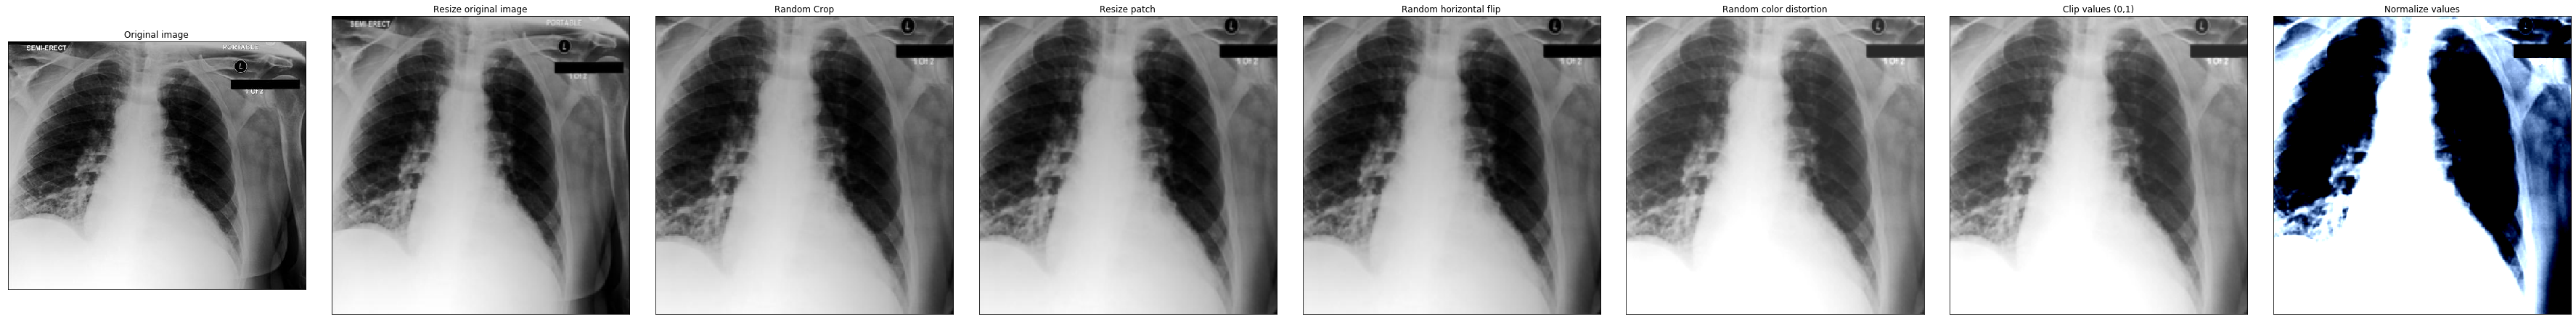

In [29]:
def plot(imgs, with_orig=True, row_title=None):
    num_cols = len(imgs)
    fig, axs = plt.subplots(nrows=1, ncols=num_cols, squeeze=False,figsize=(50,50))
    for i in range(0, len(imgs)):
        ax = axs[0, i]
        ax.imshow(imgs[i].permute(1,2,0))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=row_title[i])
        
    matplotlib.rcParams.update({'font.size': 30})
    plt.tight_layout()

import matplotlib

plot(img_array, row_title = titles)

In [30]:
def initiate_logger():
    logger = pl_loggers.NeptuneLogger(project="nyuad-cai/cl-img-ehr",
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NWU2ZThkMy03N2Q5LTQyNDYtOTc4MS04MTZkN2ViMjVjZGIifQ==") #save_dir
    
    return logger

In [31]:
pretrained_filename = '/data/farah/code/mml-ehr-imaging/contrastive-learning/checkpoints/SimCLR-CXREHR-v19.ckpt'
simclr_model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters

temp_model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
temp_model


In [32]:
@torch.no_grad()
def prepare_data_features(model, data_loader):
    # Prepare model
    network = deepcopy(model)
    #network.cxr_model.vision_backbone.fc = nn.Identity() # Removing projection head g(.) keep it for now
    network.ehr_model.dense_layer = nn.Identity() # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
#     data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats_ehr, feats_imgs, labels_ehr, labels_imgs = [], [], [], []
    #ehr_data, cxr_data, labels_ehr, labels_cxr
    
    for batch_ehr, batch_imgs, batch_ehr_labels, batch_cxr_labels, seq_lengths, pairs in tqdm(data_loader):
        batch_ehr = torch.from_numpy(batch_ehr).float().to(device)
        batch_imgs = batch_imgs.to(device)
        
        batch_ehr_feats = network.ehr_model(batch_ehr, seq_lengths)
        batch_imgs_feats = network.cxr_model(batch_imgs)
        
        feats_ehr.append(batch_ehr_feats.detach().cpu())
        feats_imgs.append(batch_imgs_feats.detach().cpu())
        
        labels_ehr.append(torch.from_numpy(batch_ehr_labels).detach())
        labels_imgs.append(batch_cxr_labels)

    feats_ehr = torch.cat(feats_ehr, dim=0)
    feats_imgs = torch.cat(feats_imgs, dim=0)
    
    labels_ehr = torch.cat(labels_ehr, dim=0)
    labels_imgs = torch.cat(labels_imgs, dim=0)

#     # Sort images by labels
#     labels, idxs = labels.sort()
#     feats = feats[idxs]

    return data.TensorDataset(feats_ehr, feats_imgs, labels_ehr, labels_imgs)

In [33]:
train_dl, val_dl, test_dl = load_cxr_ehr(args, ehr_train_ds, ehr_val_ds, cxr_train_ds, cxr_val_ds, ehr_test_ds, cxr_test_ds)

7756
882
2166


In [34]:
train_feats_simclr = prepare_data_features(simclr_model, train_dl)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [35]:
val_feats_simclr = prepare_data_features(simclr_model, val_dl)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [36]:
test_feats_simclr = prepare_data_features(simclr_model, test_dl)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [37]:
LABEL_COLUMNS = ['Acute and unspecified renal failure',
                 'Acute cerebrovascular disease',
                 'Acute myocardial infarction',
                 'Cardiac dysrhythmias',
                 'Chronic kidney disease',
                 'Chronic obstructive pulmonary disease and bronchiectasis',
                 'Complications of surgical procedures or medical care',
                 'Conduction disorders',
                 'Congestive heart failure; nonhypertensive',
                 'Coronary atherosclerosis and other heart disease',
                 'Diabetes mellitus with complications',
                 'Diabetes mellitus without complication',
                 'Disorders of lipid metabolism',
                 'Essential hypertension',
                 'Fluid and electrolyte disorders',
                 'Gastrointestinal hemorrhage',
                 'Hypertension with complications and secondary hypertension',
                 'Other liver diseases',
                 'Other lower respiratory disease',
                 'Other upper respiratory disease',
                 'Pleurisy; pneumothorax; pulmonary collapse',
                 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
                 'Respiratory failure; insufficiency; arrest (adult)',
                 'Septicemia (except in labor)',
                 'Shock',]

In [38]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, hidden_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        feature_dim = hidden_dim*2
        self.model = nn.Sequential(nn.Linear(feature_dim, num_classes), nn.Sigmoid())
        self.LABEL_COLUMNS = ['Acute and unspecified renal failure',
                 'Acute cerebrovascular disease',
                 'Acute myocardial infarction',
                 'Cardiac dysrhythmias',
                 'Chronic kidney disease',
                 'Chronic obstructive pulmonary disease and bronchiectasis',
                 'Complications of surgical procedures or medical care',
                 'Conduction disorders',
                 'Congestive heart failure; nonhypertensive',
                 'Coronary atherosclerosis and other heart disease',
                 'Diabetes mellitus with complications',
                 'Diabetes mellitus without complication',
                 'Disorders of lipid metabolism',
                 'Essential hypertension',
                 'Fluid and electrolyte disorders',
                 'Gastrointestinal hemorrhage',
                 'Hypertension with complications and secondary hypertension',
                 'Other liver diseases',
                 'Other lower respiratory disease',
                 'Other upper respiratory disease',
                 'Pleurisy; pneumothorax; pulmonary collapse',
                 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
                 'Respiratory failure; insufficiency; arrest (adult)',
                 'Septicemia (except in labor)',
                 'Shock',]
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[int(self.hparams.max_epochs*0.6),
                                                      int(self.hparams.max_epochs*0.8)],gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats_ehr, feats_img, labels_ehr, labels_img = batch
        preds = self.model(torch.cat((feats_ehr, feats_img),dim=1))
        loss = nn.BCELoss()(preds, labels_ehr.float())
        #auroc = roc_auc_score(labels_ehr, preds.detach().numpy())

        on_step=True
        on_epoch=True
        self.log(mode + '_loss', loss, on_step=on_step, on_epoch=on_epoch, logger=True)
        #self.log(mode + '_auroc', auroc, on_step=False, on_epoch=on_epoch, logger=True)
        return {"loss": loss, "predictions": preds, "labels": labels_ehr}
        
    def _calculate_auroc_epoch(self, outputs, mode):
        labels = []
        predictions = []
        auroc_label={}
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = roc_auc_score(labels[:, i], predictions[:, i])
            auroc_label[name]=class_roc_auc
            
        auroc = roc_auc_score(labels, predictions)
        self.log(mode + '_auroc', auroc, on_epoch=True, logger=True)
        self.log(mode + '_auroc_label', auroc_label, on_epoch=True, logger=True)
        
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='val')       

    def test_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='test')
        
    def training_epoch_end(self, outputs):
        self._calculate_auroc_epoch(outputs, mode='train')
        
    def validation_epoch_end(self, outputs):
         self._calculate_auroc_epoch(outputs, mode='val')        
          
    def test_epoch_end(self, outputs):
         self._calculate_auroc_epoch(outputs, mode='test')    


In [39]:
def trainer_return(batch_size, train_feats_data, val_feats_data, test_feats_data, model_suffix, logger, CHECKPOINT_PATH, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         gpus=[1] if str(device)=='cuda:1' else [0],
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_auroc'),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=0,
                         check_val_every_n_epoch=1,
                        logger=logger)
    trainer.logger._default_hp_metric = None
    val_loader = data.DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
    


    
    return trainer, val_loader, test_loader

In [40]:
def train_logreg(batch_size, train_feats_data, val_feats_data, test_feats_data, model_suffix, logger, CHECKPOINT_PATH, device, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         gpus=[1] if str(device)=='cuda:1' else [0],
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_auroc'),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=0,
                         check_val_every_n_epoch=1,
                        logger=logger)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    val_loader = data.DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
    

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) 
        model = LogisticRegression(**kwargs)
        print("Training model")
        trainer.fit(model, train_loader, val_loader)
        print(trainer.checkpoint_callback.best_model_path)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    print("Evaluating model")
    train_result = trainer.test(model, test_dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_auroc"], "test": test_result[0]["test_auroc"]}

    return model, result

In [41]:
device='cuda:1'
results = {}
neptune_logger = initiate_logger()
_, small_set_results = train_logreg(batch_size=48,
                                    train_feats_data=train_feats_simclr,
                                    test_feats_data=test_feats_simclr,
                                    val_feats_data=val_feats_simclr,
                                    model_suffix='dummy',
                                    hidden_dim=train_feats_simclr.tensors[0].shape[1],
                                    num_classes=25,
                                    lr=1e-3,
                                    weight_decay=1e-3,
                                    max_epochs=50,
                                   logger=neptune_logger,
                                    CHECKPOINT_PATH=CHECKPOINT_PATH,
                                   device=device)
results['dummy'] = small_set_results


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training model
https://app.neptune.ai/nyuad-cai/cl-img-ehr/e/CLIM-87
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 6.4 K 
-------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)
Global seed set to 42
Error occurred during asynchronous operation processing: Cannot upload file /data/farah/code/mml-ehr-imaging/contrastive-learning/.neptune/Untitled/CLIM-87/checkpoints/epoch=0-step=160.ckpt: Path not found or is a not a file.
Error occurred during asynchronous operation processing: Cannot upload file /data/farah/code/mml-ehr-imaging/contrastive-learning/.neptune/Untitled/CLIM-87/checkpoints/epoch=1-step=321.ckpt: Path not found or is a not a file.
Error occurred during asynchronous operation processing: Cannot upload file /data/farah/code/mml-ehr-imaging/contrastive-learning/.neptune/Untitled/CLIM-87/checkpoints/epoch=2-step=482.ckpt: Path not found or is a not a file.
Error occurred during asynchr

/data/farah/code/mml-ehr-imaging/contrastive-learning/.neptune/Untitled/CLIM-87/checkpoints/epoch=48-step=7888.ckpt
Evaluating model


Error occurred during asynchronous operation processing: Cannot upload file /data/farah/code/mml-ehr-imaging/contrastive-learning/.neptune/Untitled/CLIM-87/checkpoints/epoch=47-step=7727.ckpt: Path not found or is a not a file.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=47-step=7727: Attribute does not exist


In [42]:
results['dummy']

{'train': 0.6821726079226461, 'test': 0.6482792161584746}

In [23]:
path='/data/farah/code/mml-ehr-imaging/contrastive-learning/.neptune/Untitled/CLIM-51/checkpoints/epoch=146-step=17786.ckpt'

model = LogisticRegression.load_from_checkpoint(path)

trainer, val_loader, test_loader = trainer_return(batch_size=48,
                                    train_feats_data=train_feats_simclr,
                                    test_feats_data=test_feats_simclr,
                                    val_feats_data=val_feats_simclr,
                                    model_suffix='dummy',
                                    hidden_dim=train_feats_simclr.tensors[0].shape[1],
                                    num_classes=25,
                                    lr=1e-3,
                                    weight_decay=1e-3,
                                    max_epochs=200,
                                   logger=neptune_logger,
                                    CHECKPOINT_PATH=CHECKPOINT_PATH)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
temp_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [25]:
import pandas as pd
labels_results = pd.DataFrame.from_dict(temp_result[0]['test_auroc_label'], orient='index')
labels_results.rename(columns={0:'AUROC'}).sort_values('AUROC', ascending=False)

,AUROC
Respiratory failure; insufficiency; arrest (adult),"tensor(0.6550, device='cuda:1', dtype=torch.fl..."
Pneumonia (except that caused by tuberculosis or sexually transmitted disease),"tensor(0.6547, device='cuda:1', dtype=torch.fl..."
Acute cerebrovascular disease,"tensor(0.6439, device='cuda:1', dtype=torch.fl..."
Disorders of lipid metabolism,"tensor(0.5853, device='cuda:1', dtype=torch.fl..."
Fluid and electrolyte disorders,"tensor(0.5793, device='cuda:1', dtype=torch.fl..."
Gastrointestinal hemorrhage,"tensor(0.5517, device='cuda:1', dtype=torch.fl..."
Other lower respiratory disease,"tensor(0.5488, device='cuda:1', dtype=torch.fl..."
Shock,"tensor(0.5485, device='cuda:1', dtype=torch.fl..."
Essential hypertension,"tensor(0.5384, device='cuda:1', dtype=torch.fl..."
Other upper respiratory disease,"tensor(0.5365, device='cuda:1', dtype=torch.fl..."


In [88]:
def get_smaller_dataset(original_dataset):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

In [89]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

RuntimeError: unflatten: Provided sizes [10, -1] don't multiply up to the size of dim 0 (7744) in the input tensor

In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

In [2]:
import numpy as np

In [9]:
np.random.uniform(0,1,1)

array([0.27988869])

In [10]:
224//10

22

In [84]:
parser = argparse.ArgumentParser()
parser.add_argument('-x', action='store_true')

_StoreTrueAction(option_strings=['-x'], dest='x', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [82]:
args2=parser.parse_args(['--x', '1'])

usage: ipykernel_launcher.py [-h] [-x]
ipykernel_launcher.py: error: unrecognized arguments: --x 1


SystemExit: 2

In [91]:
hidden_dim = 128

test_model = torchvision.models.resnet34(pretrained=True)
num_classes=4*hidden_dim
        
classifiers = [ 'classifier', 'fc']
for classifier in classifiers:
    cls_layer = getattr(test_model, classifier, None)
    if cls_layer is None:
        continue
    d_visual = cls_layer.in_features
    setattr(test_model, classifier, nn.Identity(d_visual))
    break
test_model.bce_loss = torch.nn.BCELoss(size_average=True)
#self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.vision_num_classes), nn.Sigmoid())
test_model.feats_dim = d_visual
        

In [92]:
test_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
bs = 16
temperature = 0.01
t1 = torch.rand(bs, 1, 128)
t2 = torch.rand(bs, 1, 128)

In [22]:
cos_sim = F.cosine_similarity(t1[:,None,:], t2[None,:,:], dim=-1)
cos_sim = cos_sim / temperature
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool)
self_mask = self_mask[:, :, None]
cos_sim_negative = torch.clone(cos_sim)
cos_sim_negative.masked_fill_(self_mask, -9e15)
print(-cos_sim[self_mask])
nll = -cos_sim[self_mask] + torch.logsumexp(cos_sim_negative, dim=1).reshape(1,16)
print(nll)
nll = nll.mean()
nll

tensor([-73.2677, -74.2873, -74.5485, -77.1219, -74.5835, -74.6408, -75.5901,
        -70.3725, -74.0316, -73.7787, -74.8576, -75.8895, -70.4818, -77.5283,
        -74.8488, -77.5438])
tensor([[5.5359, 7.1143, 5.8009, 2.7824, 5.3610, 6.8727, 5.9162, 8.9064, 5.1567,
         5.0357, 5.3965, 4.8128, 9.7074, 3.0825, 6.3498, 0.8564]])


tensor(5.5430)

In [23]:
cos_sim = F.cosine_similarity(t2[:,None,:], t1[None,:,:], dim=-1)
cos_sim = cos_sim / temperature
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool)
self_mask = self_mask[:, :, None]
cos_sim_negative = torch.clone(cos_sim)
cos_sim_negative.masked_fill_(self_mask, -9e15)
print(-cos_sim[self_mask])
nll = -cos_sim[self_mask] + torch.logsumexp(cos_sim_negative, dim=1).reshape(1,16)
print(nll)
nll = nll.mean()
nll

tensor([-73.2677, -74.2873, -74.5485, -77.1219, -74.5835, -74.6408, -75.5901,
        -70.3725, -74.0316, -73.7787, -74.8576, -75.8895, -70.4818, -77.5283,
        -74.8488, -77.5438])
tensor([[ 6.9227,  4.7145,  5.1672,  0.2367,  7.3432,  4.4662,  5.5451, 10.0411,
          7.0676,  7.2622,  4.0970,  3.7236,  7.1632,  1.9709,  2.8759,  4.2192]])


tensor(5.1760)

In [285]:
temp=torch.reshape(cos_sim, (cos_sim.shape[0],cos_sim.shape[1]))
temp = temp.argsort(dim=1, descending=True)[:, :1]
batchsize=16
b_idx = np.arange(0,batchsize)
tot=0
for j in range(0, batchsize):
    tot+= b_idx[j] in temp[j]
tot*100/batchsize

100.0

In [128]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([[301,302]], [[104.2, 109.2]])


array([[0.9997631]])

In [124]:
data_1 = [[1, 2], [104, 109], [301,302]]
a = torch.tensor(data_1)

data_2 = [[1.2, 2.2], [104.2, 109.2], [301.9,302.9]]
b = torch.tensor(data_2)

print(a)
print(b)

tensor([[  1,   2],
        [104, 109],
        [301, 302]])
tensor([[  1.2000,   2.2000],
        [104.2000, 109.2000],
        [301.9000, 302.9000]])


In [125]:

cos_sim

tensor([[0.9994, 0.9558, 0.9492],
        [0.9657, 1.0000, 0.9998],
        [0.9598, 0.9998, 1.0000]])

In [179]:
cos_sim = F.cosine_similarity(a[:,None,:], b[None,:,:], dim=-1)
cos_sim = cos_sim/0.1
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool)
cos_sim_negative = torch.clone(cos_sim)
cos_sim_negative.masked_fill_(self_mask, -9e15)

# print(cos_sim[self_mask])
# print(torch.logsumexp(cos_sim_negative, dim=1))
# print(cos_sim[self_mask]- torch.logsumexp(cos_sim_negative, dim=1))
-(cos_sim[self_mask]- torch.logsumexp(cos_sim_negative, dim=1)).mean()


tensor(0.4237)

In [183]:
-(cos_sim[self_mask]- torch.logsumexp(cos_sim_negative, dim=1)).mean()+-(cos_sim[self_mask]- torch.logsumexp(cos_sim_negative, dim=0)).mean()


tensor(0.8545)

In [185]:
# Compute based on img->ehr
nll_1 = cos_sim[self_mask] - torch.logsumexp(cos_sim_negative, dim=1)
print(nll_1.mean())
        
# Compute based on ehr->img
nll_2 = cos_sim[self_mask] - torch.logsumexp(cos_sim_negative, dim=0)        
print(nll_2.mean())

# Total loss 
loss = -(nll_1 + nll_2).mean()
print(loss)

tensor(-0.4237)
tensor(-0.4308)
tensor(0.8545)


In [169]:
# THE CORRECT CALCULATION
temp = 0.1

cos_sim = F.cosine_similarity(a[:,None,:], b[None,:,:], dim=-1)
print(cos_sim)

# Modality A to Modality B
a1b = np.log(np.exp(0.9994/temp)/(np.exp(0.9558/temp)+np.exp(0.9492/temp)).mean())
a2b = np.log(np.exp(1/temp)/(np.exp(0.9657/temp)+np.exp(0.9998/temp)).mean())
a3b = np.log(np.exp(1/temp)/(np.exp(0.9598/temp)+np.exp(0.9998/temp)).mean())
print(a1b, a2b, a3b)
print(-np.mean([a1b, a2b, a3b]))

tensor([[0.9994, 0.9558, 0.9492],
        [0.9657, 1.0000, 0.9998],
        [0.9598, 0.9998, 1.0000]])
-0.22469158176188478 -0.5351124234269201 -0.5110152523999517
0.42360641919625214


In [170]:
# Modality B to Modality A
b1a = np.log(np.exp(0.9994/temp)/(np.exp(0.9657/temp)+np.exp(0.9598/temp)).mean())
b2a = np.log(np.exp(1/temp)/(np.exp(0.9558/temp)+np.exp(0.9998/temp)).mean())
b3a = np.log(np.exp(1/temp)/(np.exp(0.9492/temp)+np.exp(0.9998/temp)).mean())
print(b1a, b2a, b3a)
print(-np.mean([b1a, b2a, b3a]))

-0.32708224246333206 -0.4951544503321094 -0.46981596815689547
0.43068422031744563


In [181]:
-((a1b+b1a)+(a2b+b2a)+(a3b+b3a))/3

0.8542906395136978

In [186]:
int(0.05*50)

2

In [216]:
7756/512

15.1484375

In [220]:
0.0001*np.sqrt(512)

0.002262741699796952

In [219]:
0.0001*512/64

0.0008

In [226]:

s1 = '/data/farah/code/mml-ehr-imaging/contrastive-learning/checkpoints/SimCLR-CXREHR-v40000.ckpt'
s1.split('.ckpt')[0].split('SimCLR-CXREHR-')[1]

'v40000'

In [1]:
import torch

ModuleNotFoundError: No module named 'torch'

In [1]:
import numpy

ModuleNotFoundError: No module named 'numpy'